# Kriging

Kriging is a stochastic process regression while only using Gaussian-distributed data. This is also called a Gaussian process regression.

## Gaussian process regression
The outcome of a Gaussian process is a Gaussian-distributed variable acting on the set $S$:
$$
    X^*(s) \sim \mathcal{N} \left( \sum\limits_{i=1}^N \phi_i(s) f_i, k(s,s) - \sum\limits_{i=1}^N \phi_i(s)k(s_i, s) \right).
$$

The functions $\phi_i$ can be obtained by solving the system of linear equation:
$$
    \left(\begin{array}{ccc}
        k(s_1,s_1) & \dots & k(s_1, k_N) \\
        \vdots & \ddots & \vdots \\
        k(s_N, s_1) & \dots & k(s_N, s_N)
    \end{array}\right) \left(\begin{array}{c}
        \phi_1 \\
        \vdots \\
        \phi_N
    \end{array}\right) = \left(\begin{array}{c}
        k(s_1, s) \\
        \vdots \\
        k(s_N, s)
    \end{array}\right),
$$
while $f_i, i = 1, \dots, N$ are the prior mean values at the corresponding sampled position $s_i$ and the function $k: S \times S \to \mathbb{R}$ is a suitable covariance function, e.g. the squared exponential $k(s_i,s_j) = \sigma_p^2 \exp (- \frac{1}{2l^2} \vert s_i - s_j \vert^2)$. In short, the solution to this system of equations is as followed:
$$
    \phi_i(s) = \sum\limits_{j=1}^N (K_{ij})^{-1} k(s_j, s).
$$

Schlegel et al. included the variance of the sampled values $\sigma_i^2, i \in \{1, \dots, N\}$ into the covariance matrix $K$ by adding them to the diagonal values. This results for diagonal values to $K_{ii} = k(s_i,s_i) + \sigma_i^2, i \in \{1,\dots,N\}$.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets as widgets

In [41]:
def cov(s_i, s_j, var_p=1.0, l=1.0, norm=2):
    '''
    Squarred exponential function.

    Parameters
    ----------
    s_i: array_like
        First point.
    s_j: array_like
        Second point.
    var_p: float
        Prior varince.
    l: float
        Length scale.

    Returns
    -------
    float
        The covariance of the two points.
    '''
    return var_p * np.exp( - 1 / ( 2 * l **2 ) * np.linalg.norm(s_i - s_j, norm)**2 )

def phi(s, S, K_i_inv, var_p=1.0, l=1.0):
    '''
    Computes the :math:´\phi´ according to the position :math:´s´.

    Parameters
    ----------
    s: array_like
        The position to interpolate.
    S: array_like
        The known sampled positions.
    K_i_inv: array_like
        The i-th row of the inverse system matrix.
    var_p: float
        Prior varince.
    l: float
        The influence of the distance on the interpolation.

    Returns
    -------
    float
        The :math:´phi´ of the i-th row solving the system of equations.
    '''
    K_i = np.array([cov(s_i, s, var_p, l) for s_i in S])
    phi_i = K_i_inv * K_i
    return np.sum(phi_i)

def kriging(S, f, var, s_interpolated, var_p, l):
    '''
    Computes a multivatiate random field using kriging based on the observed points `S` and values `f`.

    Parameters
    ----------
    S: array_like
        Sampled points positions.
    f: array_like
        Values observed at the sampled points.
    var: array_like
        The (estimated) variance of the observed values.
    s_interpolated: array_like
        Points to interpolate the new values.
    var_p: float
        Prior varince.
    l: float
        The influence of the distance on the interpolation.

    Returns
    -------
    mu_interpolated: array_like
        The interpolated mean values.
    var_interplated: array_like
        The interpolated variance.
    '''
    K = np.array([
    [cov(S[i], S[j], var_p, l) for j in range(len(f))]
        for i in range(len(f))])
    K += np.diag(var)

    mu_interpolated = np.empty(len(s_interpolated),)
    var_interpolated = np.empty(len(s_interpolated),)
    for idx,s in enumerate(s_interpolated):
        b = np.array([cov(S[i], s, var_p, l) for i in range(len(S))])

        Phi = np.linalg.solve(K, b)
        
        mu_interpolated[idx] = np.sum( Phi * f )
        var_interpolated[idx] = cov(s, s) - np.sum(Phi * b)

    mu_interpolated = mu_interpolated.reshape(50,50)
    var_interpolated = var_interpolated.reshape((50,50))

    return mu_interpolated, var_interpolated

In [42]:
# input, observations
S = np.array([
    [0., 0.],
    [1., 0.],
    [0., 1.],
    [1., 1.]
])
f = np.array([
    1., 1.,
    0, -1.])

# interpolation points
x = np.linspace(0, 1)
y = np.linspace(0, 1)
s_interpolated = np.transpose(np.meshgrid(x, y), [1,2,0]).reshape((-1,2))

mu1, var1 = kriging(S, f, np.ones_like(f), s_interpolated, 1.0, 0.2)
mu2, var2 = kriging(S, f, np.zeros_like(f), s_interpolated, 1.0, 0.2)
mu3, var3 = kriging(S, f, np.zeros_like(f), s_interpolated, 1.0, 0.7)

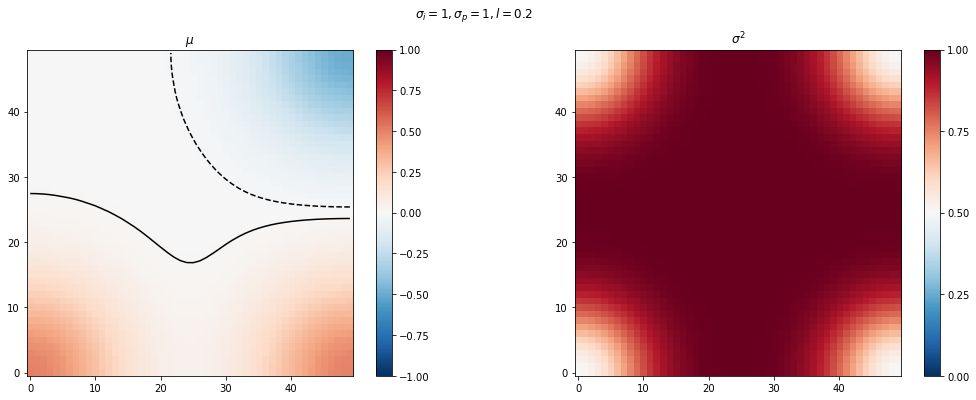

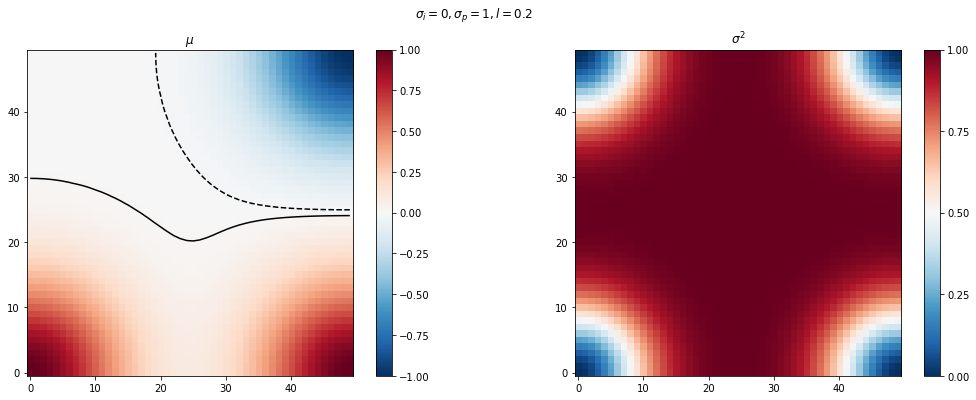

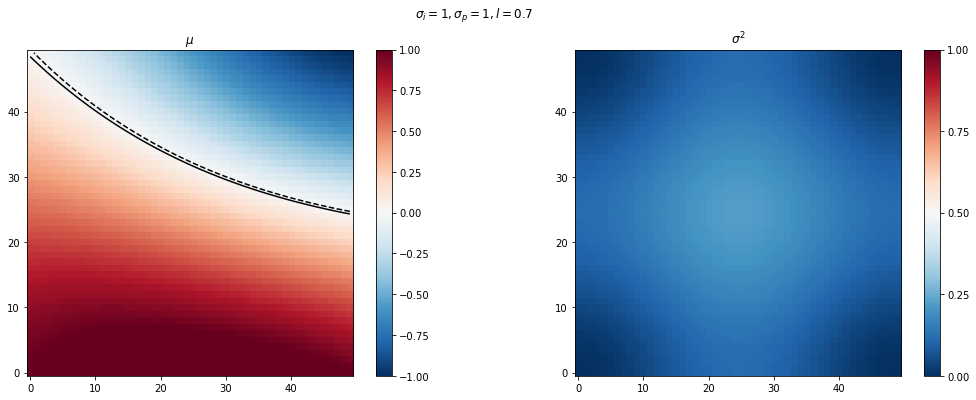

In [43]:
plt.figure(figsize=(18,6))
plt.suptitle(r'$\sigma_i = 1, \sigma_p = 1, l = 0.2$')
plt.subplot(1,2,1)
plt.title(r'$\mu$')
plt.contour(mu1, levels=[-0.01, 0.01], colors='k')
plt.imshow( mu1, interpolation='none', origin='lower', cmap='RdBu_r', vmin=-1, vmax=1 )
plt.colorbar()

plt.subplot(1,2,2)
plt.title(r'$\sigma^2$')
plt.imshow( var1, interpolation='none', origin='lower', cmap='RdBu_r', vmin=0, vmax=1 )
cbar = plt.colorbar()
cbar.set_ticks(np.linspace(0,1, 5))

plt.show()

plt.figure(figsize=(18,6))
plt.suptitle(r'$\sigma_i = 0, \sigma_p = 1, l = 0.2$')
plt.subplot(1,2,1)
plt.title(r'$\mu$')
plt.contour(mu2, levels=[-0.01, 0.01], colors='k')
plt.imshow( mu2, interpolation='none', origin='lower', cmap='RdBu_r', vmin=-1, vmax=1 )
plt.colorbar()

plt.subplot(1,2,2)
plt.title(r'$\sigma^2$')
plt.imshow( var2, interpolation='none', origin='lower', cmap='RdBu_r', vmin=0, vmax=1 )
cbar = plt.colorbar()
cbar.set_ticks(np.linspace(0,1, 5))

plt.show()

plt.figure(figsize=(18,6))
plt.suptitle(r'$\sigma_i = 1, \sigma_p = 1, l = 0.7$')
plt.subplot(1,2,1)
plt.title(r'$\mu$')
plt.contour(mu3, levels=[-0.01, 0.01], colors='k')
plt.imshow( mu3, interpolation='none', origin='lower', cmap='RdBu_r', vmin=-1, vmax=1 )
plt.colorbar()

plt.subplot(1,2,2)
plt.title(r'$\sigma^2$')
plt.imshow( var3, interpolation='none', origin='lower', cmap='RdBu_r', vmin=0, vmax=1 )
cbar = plt.colorbar()
cbar.set_ticks(np.linspace(0,1, 5))

plt.show()

In [44]:
# input, observations
S = np.array([
    [0., 0.],
    [1., 0.],
    [0., 1.],
    [1., 1.]
])
f = np.array([
    1., 1.,
    -1., 0.])
var_i = np.array([
    1.0, 1.0,
    1.0, 1.0])

var_p = 1.0
l = 0.2

K = np.array([
    [cov(S[i], S[j], var_p, l) for j in range(len(f))]
        for i in range(len(f))])
K += np.diagflat(var_i)

mu_interpolated = np.empty((len(s_interpolated),))
var_interpolated = np.empty((len(s_interpolated),))
for idx,s in enumerate(s_interpolated):
    b = np.array([cov(S[i], s, var_p, l) for i in range(len(S))])

    Phi = np.linalg.solve(K, b)

    mu_interpolated[idx] = np.sum(Phi * f)
    var_interpolated[idx] = cov(s, s) - np.sum(Phi * b)

mu_interpolated = mu_interpolated.reshape(50,50)
var_interpolated = var_interpolated.reshape((50,50))

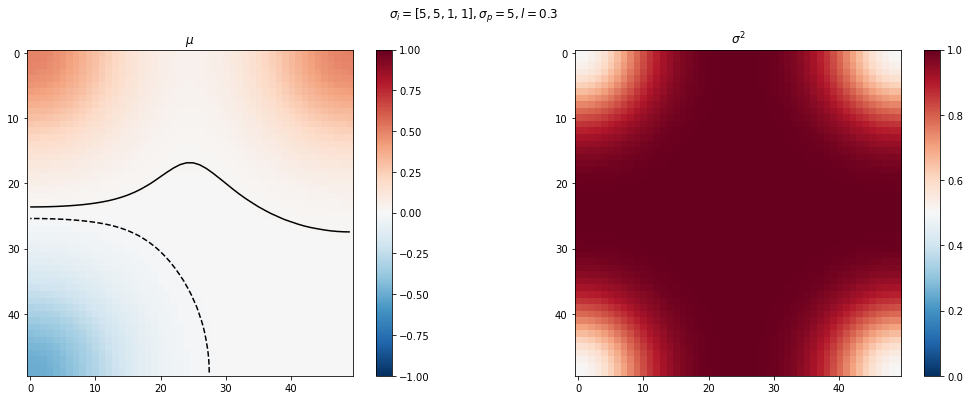

In [45]:
plt.figure(figsize=(18,6))
plt.suptitle(r'$\sigma_i = [5, 5, 1, 1], \sigma_p = 5, l = 0.3$')
plt.subplot(1,2,1)
plt.title(r'$\mu$')
plt.contour(mu_interpolated, levels=[-0.01, 0.01], colors='k')
plt.imshow( mu_interpolated, interpolation='none', cmap='RdBu_r', vmin=-1, vmax=1 )
plt.colorbar()

plt.subplot(1,2,2)
plt.title(r'$\sigma^2$')
plt.imshow( var_interpolated, interpolation='none', cmap='RdBu_r', vmin=0, vmax=var_i.max() )
cbar = plt.colorbar()

plt.show()

In [8]:
rng = np.random.default_rng()

@widgets.interact(idx=widgets.Play(min=0,max=100, step=1, interval=50))
def show_samples(idx=0):
    sample = rng.normal(mu_interpolated, np.sqrt(var_interpolated))

    plt.figure(figsize=(18,6))
    plt.suptitle(r'$\sigma_i = [5, 5, 1, 1], \sigma_p = 5, l = 0.3$')
    plt.imshow( sample, interpolation='none', cmap='RdBu_r', vmin=-1, vmax=1 )
    plt.colorbar()

    plt.show()

interactive(children=(Play(value=0, description='idx', interval=50), Output()), _dom_classes=('widget-interact…